In [1]:
import pandas as pd
import numpy as np
from category_encoders import CatBoostEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import shap
from xgboost import XGBRegressor

c:\Users\cmfar\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("imdb.csv")
df = df.drop(["id", "backdrop_path", "homepage", "tconst", "poster_path", "tagline", "original_title", "title", "adult", "production_countries", "overview", "release_date"], axis=1)

df["status"] = df["status"].astype("string")
df["original_language"] = df["original_language"].astype("string")
df["production_companies"] = df["production_companies"].astype("string")
df["spoken_languages"] = df["spoken_languages"].astype("string")
df["genres"] = df["genres"].astype("string")
df["keywords"] = df["keywords"].astype("string")
df["cast"] = df["cast"].astype("string")
df["writers"] = df["writers"].astype("string")
df["directors"] = df["directors"].astype("string")

df = df.dropna()

df.head()
print(len(df))
print(df.info())


108503
<class 'pandas.core.frame.DataFrame'>
Index: 108503 entries, 0 to 434801
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vote_average          108503 non-null  float64
 1   vote_count            108503 non-null  int64  
 2   status                108503 non-null  string 
 3   revenue               108503 non-null  int64  
 4   runtime               108503 non-null  int64  
 5   budget                108503 non-null  int64  
 6   original_language     108503 non-null  string 
 7   popularity            108503 non-null  float64
 8   genres                108503 non-null  string 
 9   production_companies  108503 non-null  string 
 10  spoken_languages      108503 non-null  string 
 11  keywords              108503 non-null  string 
 12  directors             108503 non-null  string 
 13  writers               108503 non-null  string 
 14  averageRating         108503 non-null  float64
 15

In [3]:
mixed_type_cols = []

for col in df.columns:
    types = df[col].map(type).unique()
    if len(types) > 1:
        mixed_type_cols.append((col, types))

print("Columns with mixed types:")
for col, types in mixed_type_cols:
    print(f"{col}: {types}")

Columns with mixed types:


In [4]:
X = df.drop("revenue", axis=1)
y = df["revenue"]

In [5]:
categorical_cols = ["status", "original_language", "genres", "spoken_languages", "keywords", "production_companies", "directors", "writers", "cast"]
numeric_cols = ["budget", "runtime", "vote_average", "vote_count", "popularity", "averageRating", "numVotes"]

In [6]:
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("catboost_enc", CatBoostEncoder())
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)


In [8]:
xgb_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        tree_method="hist",
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)

preds_xgb = xgb_model.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds_xgb))
r2_xgb = r2_score(y_val, preds_xgb)

print(f"XGBoost → RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.3f}")


XGBoost → RMSE: 27082224.20, R²: 0.737


In [9]:
final_xgb = xgb_model.named_steps["model"]


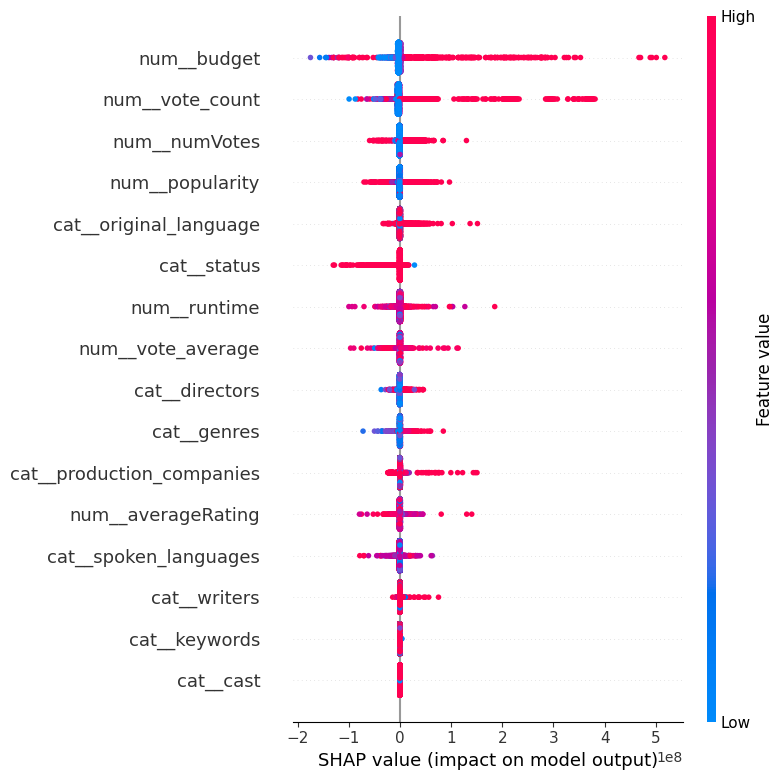

In [13]:

# Compute SHAP on preprocessed validation data
X_val_processed = xgb_model.named_steps["preprocess"].transform(X_val)
explainer = shap.TreeExplainer(final_xgb, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_val_processed, approximate=True, check_additivity=False)

# Visualize feature importance
shap.summary_plot(shap_values, X_val_processed, feature_names=xgb_model.named_steps["preprocess"].get_feature_names_out())


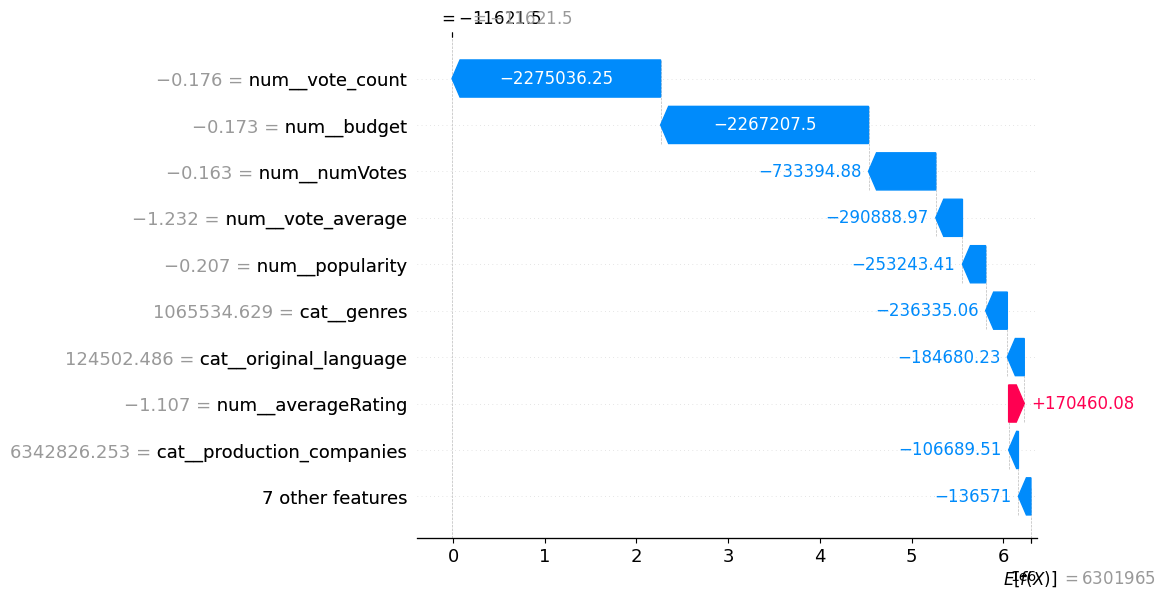

In [ ]:
preprocessor = xgb_model.named_steps["preprocess"]
booster = xgb_model.named_steps["model"]

# 2. Select the row you want to explain
test_row = X_val.iloc[[0]]

print(test_row)

# 3. Transform data through the preprocessor
test_row_enc = preprocessor.transform(test_row)
X_train_enc = preprocessor.transform(X_train)

# 4. Get expanded feature names
feature_names = preprocessor.get_feature_names_out()

# 5. Build SHAP explainer on the XGBoost booster
explainer = shap.TreeExplainer(booster)

# 6. Compute SHAP values
shap_values = explainer(test_row_enc)

# 7. Assign readable feature names
shap_values.feature_names = feature_names

# 8. Plot
shap.plots.waterfall(shap_values[0])
